
# Square Exponential Decomposition Demo

This notebook demonstrates a squared exponential covariance decomposition on the square domain [-5, 5] x [-5, 5] using the Legendre/Galerkin tools shipped in this repository. It replaces the dense covariance build with the low-rank tensor approach, exports the truncated representation to a compressed HDF5 file, and defines a lightweight loader class that can evaluate or sample the resulting Gaussian field with minimal dependencies.


In [83]:

from pathlib import Path

import h5py
import numpy as np
import opt_einsum as oe

from kl_decomposition import galerkin, kl_tensor
from kl_decomposition.orthopoly import leg_vals



## Configure squared exponential field parameters
The parameters below control the mean, variance, correlation length, polynomial resolution, and numerical quadrature. Adjust them and rerun before exporting to JSON.


In [84]:

# User-adjustable parameters
correlation_length = 0.75
variance = 4**2
mean_value = -41

# Galerkin / spectral resolution
polynomial_degree = 100  # number of Legendre polynomials per dimension
quadrature_order = 200   # Gauss-Legendre points for 1-D assembly
max_modes = 400          # eigenpairs requested across all parity blocks
energy_target = 0.99
min_modes = 30

# Domain and grid resolution
extent = (-5.0, 5.0)
grid_points = 101  # per spatial axis; adjust for higher or lower resolution


## Build grid and Galerkin ingredients
We discretize the square with a uniform grid for output and assemble the 1-D Legendre basis on the physical domain. The squared exponential kernel
$$ k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x - x' \rVert^2}{2 \ell^2}\right)
= \sigma^2 e^{-b (x_1 - x_1')^2} e^{-b (x_2 - x_2')^2}, \quad b = \tfrac{1}{2\ell^2} $$
is separable across dimensions, so the 2-D Galerkin operator reduces to a Kronecker product of identical 1-D blocks.


In [85]:

x = np.linspace(extent[0], extent[1], grid_points)
y = np.linspace(extent[0], extent[1], grid_points)
xx, yy = np.meshgrid(x, y, indexing="ij")

interval = (extent[0], extent[1])
domain_length = interval[1] - interval[0]
unit_grid = (x - interval[0]) / domain_length



## Eigen-decomposition and truncation
The tensor Krylov routine diagonalizes the separable operator without forming the full covariance matrix. Eigenvalues are sorted in descending order, and we keep enough modes to capture the desired energy fraction (or a minimum number of modes for robustness).


In [86]:

kernel_scale = 0.5 / (correlation_length ** 2)

print(f"Assembling 1-D Galerkin block with degree={polynomial_degree}, quad={quadrature_order}...")
A_block = galerkin.assemble_block(interval, kernel_scale, polynomial_degree, quad_order=quadrature_order)

print("Computing tensor-product eigenpairs across 2-D domain...")
eigvals_blocks, eigvecs_blocks = kl_tensor.spectral_blocks(
    [A_block],
    g_coeff=[variance],
    n=2,
    N_eval=max_modes,
)

def evaluate_modes_on_grid(eigvals, eigvecs, degree, unit_grid_1d, length):
    """Evaluate sorted eigenfunctions on the physical tensor grid."""
    phi_all = leg_vals(degree, unit_grid_1d) / np.sqrt(length)
    phi_even = phi_all[0::2]
    phi_odd = phi_all[1::2]

    coeff_idx = "ab"
    grid_idx = "uv"
    einsum_rhs = "abz,au,bv->uvz"

    lambdas = []
    psi_grid = []

    for bits, block_vals in eigvals.items():
        vecs = eigvecs[bits]
        n_block = vecs.shape[1]
        dims = tuple(phi_even.shape[0] if bit == 0 else phi_odd.shape[0] for bit in bits)
        coeff_tensor = vecs.reshape(*dims, n_block)
        phi_list = [phi_even if bit == 0 else phi_odd for bit in bits]
        psi_all = oe.contract(einsum_rhs, coeff_tensor, *phi_list, optimize=True)
        lambdas.extend(block_vals.tolist())
        psi_grid.extend([psi_all[..., k] for k in range(n_block)])

    order = np.argsort(lambdas)[::-1]
    eigenvalues = np.asarray(lambdas)[order]
    eigenfunctions = [psi_grid[i] for i in order]
    return eigenvalues, eigenfunctions

sorted_evals, eigenfunctions = evaluate_modes_on_grid(
    eigvals_blocks,
    eigvecs_blocks,
    polynomial_degree,
    unit_grid,
    domain_length,
)

# Flatten eigenfunctions in row-major order to match np.meshgrid(..., indexing="ij")
eigenvectors_matrix = np.stack([fn.ravel() for fn in eigenfunctions], axis=1)

energy = np.cumsum(sorted_evals) / np.sum(sorted_evals)
cutoff_idx = np.searchsorted(energy, energy_target)
keep = max(min_modes, cutoff_idx + 1)

kept_evals = sorted_evals[:keep]
kept_evecs = eigenvectors_matrix[:, :keep]

keep


Assembling 1-D Galerkin block with degree=100, quad=200...
Computing tensor-product eigenpairs across 2-D domain...


np.int64(152)


## Export decomposition to HDF5
The HDF5 file stores the grid, parameters, eigenvalues, and eigenvectors with gzip compression to keep the file size small while remaining easy to load with `h5py`.


In [87]:

out_path = Path("data/square_exponential_decomposition.h5")
out_path.parent.mkdir(parents=True, exist_ok=True)

with h5py.File(out_path, "w") as f:
    f.attrs["description"] = "Squared exponential covariance decomposition on [-5, 5]^2"
    f.attrs["grid_extent_min"] = extent[0]
    f.attrs["grid_extent_max"] = extent[1]
    f.attrs["grid_points"] = grid_points
    f.attrs["mean"] = mean_value
    f.attrs["variance"] = variance
    f.attrs["correlation_length"] = correlation_length

    f.create_dataset("grid_x", data=x, compression="gzip", compression_opts=9, shuffle=True)
    f.create_dataset("grid_y", data=y, compression="gzip", compression_opts=9, shuffle=True)
    f.create_dataset("eigenvalues", data=kept_evals, compression="gzip", compression_opts=9, shuffle=True)
    # Eigenvectors stored as (modes, n_points) for compactness
    f.create_dataset(
        "eigenvectors",
        data=kept_evecs.T,
        compression="gzip",
        compression_opts=9,
        shuffle=True,
    )

out_path


PosixPath('data/square_exponential_decomposition.h5')


## Loader class for evaluation and sampling
The class below reads the exported HDF5, reconstructs the truncated basis, and exposes methods to evaluate fields from user-provided coefficients or to draw random samples.


In [88]:

class SquareExponentialField:
    """Load and evaluate a truncated squared exponential decomposition."""

    def __init__(self, mean, eigenvalues, eigenvectors, grid_x, grid_y):
        self.mean = float(mean)
        self.eigenvalues = np.asarray(eigenvalues, dtype=float)
        self.sqrt_eigenvalues = np.sqrt(self.eigenvalues)
        # Eigenvectors stored as (modes, n_points)
        self.eigenvectors = np.asarray(eigenvectors, dtype=float)
        self.grid_x = np.asarray(grid_x, dtype=float)
        self.grid_y = np.asarray(grid_y, dtype=float)
        self.grid_shape = (len(self.grid_x), len(self.grid_y))

    @classmethod
    def from_hdf5(cls, path):
        with h5py.File(path, "r") as f:
            mean = f.attrs["mean"]
            eigenvalues = f["eigenvalues"][:]
            eigenvectors = f["eigenvectors"][:]
            grid_x = f["grid_x"][:]
            grid_y = f["grid_y"][:]
        return cls(mean=mean, eigenvalues=eigenvalues, eigenvectors=eigenvectors, grid_x=grid_x, grid_y=grid_y)

    def evaluate(self, coefficients=None):
        """Evaluate the truncated expansion on the stored grid.

        Args:
            coefficients: Optional array of shape (modes,) or (n_samples, modes).
                Defaults to zeros (producing the mean field).

        Returns:
            Field values with shape (grid_x.size, grid_y.size) if coefficients is 1D,
            or (n_samples, grid_x.size, grid_y.size) if 2D.
        """
        if coefficients is None:
            coefficients = np.zeros((self.eigenvectors.shape[0],), dtype=float)
        coeffs = np.asarray(coefficients, dtype=float)

        single_input = coeffs.ndim == 1
        if single_input:
            coeffs = coeffs[None, :]

        if coeffs.shape[1] != self.eigenvectors.shape[0]:
            raise ValueError("Coefficient dimension does not match number of modes")

        weighted_modes = coeffs * self.sqrt_eigenvalues[None, :]
        fields = weighted_modes @ self.eigenvectors
        fields = fields + self.mean

        if single_input:
            return fields.reshape(self.grid_shape)
        return fields.reshape((-1, *self.grid_shape))

    def sample(self, n_samples=1, rng=None):
        """Draw random field samples using standard normal coefficients."""
        rng = np.random.default_rng(rng)
        coeffs = rng.standard_normal(size=(n_samples, self.eigenvectors.shape[0]))
        return self.evaluate(coeffs)



## Example usage
Load the saved JSON, draw a couple of random samples, and inspect their shapes.


In [89]:
import h5py
import numpy as np
field = SquareExponentialField.from_hdf5("data/square_exponential_decomposition.h5")

# Evaluate the mean field (all coefficients zero)
mean_field = field.evaluate()
extent = (-5.0, 5.0)
# Draw a few random samples
few_samples = field.sample(n_samples=3, rng=0)

mean_field.shape, few_samples.shape

((101, 101), (3, 101, 101))

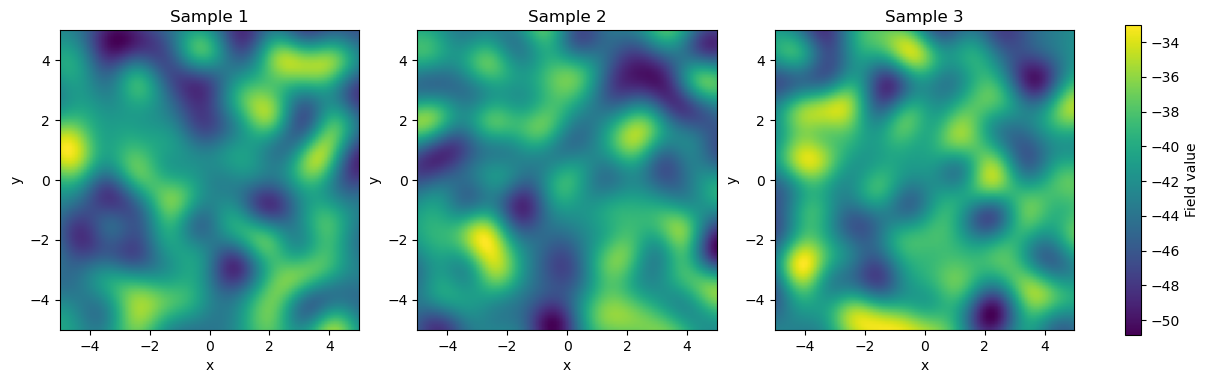

In [90]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, few_samples.shape[0], figsize=(4 * few_samples.shape[0], 4), constrained_layout=True)
axes = np.atleast_1d(axes)

for idx, (ax, sample) in enumerate(zip(axes, few_samples)):
    im = ax.imshow(
        sample,
        origin="lower",
        extent=(extent[0], extent[1], extent[0], extent[1]),
        cmap="viridis"
    )
    ax.set_title(f"Sample {idx + 1}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig.colorbar(im, ax=axes, shrink=0.8, label="Field value")
plt.show()

In [91]:
print((np.log(1e-12)-np.log(1e-21))/4)

print((np.log(1e-13)))
print((np.log(1e-21)))

5.180816459236603
-29.933606208922594
-48.35428695287496
